## Humor Detection

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
humour = open('funny2.txt','r').read().split('\n')
neg = open('not_funny2_trunc.txt','r').read().split('\n')

## Preprocessing

In [75]:
import numpy as np

texts = []
labels = []

np.random.shuffle(neg)


for line in humour:
    texts.append(line)
    labels.append(1)

for line in neg:
    texts.append(line)
    labels.append(0)

print('Funny', len(humour))    
print("Not Funny",len(neg))  
print("Total", len(texts))

Funny 7785
Not Funny 7785
Total 15570


In [76]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenizing words

# max word length
maxlen = 50
# take top 10k words only
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.array(labels)

print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

# shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Found 18905 unique tokens
Shape of data tensor: (15570, 50)
Shape of labels tensor: (15570,)


## Loading the pre-trained word embeddings

In [18]:
# due to small size of dataset
# we would use standford's GloVe pre-trained word embeddings

# download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-04-12 00:30:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-04-12 00:30:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  12.3MB/s    in 47s     

2019-04-12 00:31:04 (17.5 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [19]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [73]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coeffs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coeffs
f.close()

print(len(embeddings_index))

400000


In [0]:
# preparing glove word embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i<max_words:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # for words not in embedding index values will be zeros

## Building the model

### 1. Simple feed-forward network with dense layers on top of embedding layer --- using GloVe pre-trained word embeddings

In [77]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.optimizers import RMSprop


model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
flatten_14 (Flatten)         (None, 5000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                320064    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________


### Load the pre-trained word embeddings into the embedding layer and freeze it

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [79]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 14013 samples, validate on 1557 samples
Epoch 1/20
14013/14013 [==============================] - 4s 266us/step - loss: 0.6616 - acc: 0.6019 - val_loss: 0.6173 - val_acc: 0.6808
Epoch 2/20
14013/14013 [==============================] - 2s 173us/step - loss: 0.6004 - acc: 0.6782 - val_loss: 0.6144 - val_acc: 0.6769
Epoch 3/20
14013/14013 [==============================] - 2s 177us/step - loss: 0.5673 - acc: 0.7127 - val_loss: 0.6036 - val_acc: 0.6969
Epoch 4/20
14013/14013 [==============================] - 2s 177us/step - loss: 0.5429 - acc: 0.7317 - val_loss: 0.6022 - val_acc: 0.6911
Epoch 5/20
14013/14013 [==============================] - 3s 185us/step - loss: 0.5242 - acc: 0.7435 - val_loss: 0.6086 - val_acc: 0.6898
Epoch 6/20
14013/14013 [==============================] - 3s 181us/step - loss: 0.5050 - acc: 0.7589 - val_loss: 0.6061 - val_acc: 0.6936
Epoch 7/20
14013/14013 [==============================] - 3s 188us/step - loss: 0.4866 - acc: 0.7722 - val_loss: 0.6134 - v

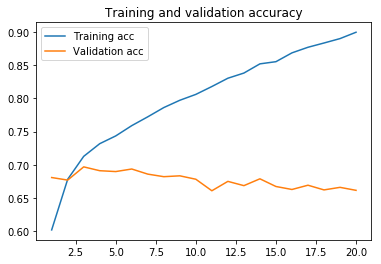

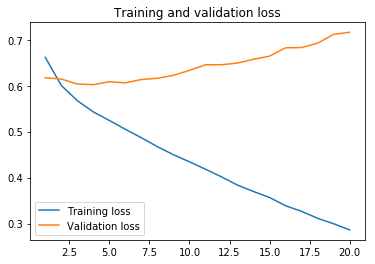

In [80]:
# plotting the results

import matplotlib.pyplot as plt
%matplotlib inline

def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_result(history)